<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Movie Recommendation System</p><br>


**Recommender systems** are the systems that are designed to recommend things to the user based on many different factors. These systems predict the most likely product that the users are most likely to purchase and are of interest to. Companies like Netflix, Amazon, etc. use recommender systems to help their users to identify the correct product or movies for them. 
<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">

<br>This notebook uses a dataset from the MovieLens website.  
* **Data Source:** MovieLens web site (filename: ml-25m.zip)
* **Location:** https://grouplens.org/datasets/movielens/



<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Import Libraries
</p>

In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [2]:
!ls Dataset

links.csv  movies.csv  ratings.csv  tags.csv


In [3]:
movies = pd.read_csv('./Dataset/movies.csv', sep=',')
print(type(movies))
movies.head()

<class 'pandas.core.frame.DataFrame'>


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

tags = pd.read_csv('./Dataset/tags.csv', sep=',')
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [5]:
ratings = pd.read_csv('./Dataset/ratings.csv', sep=',', parse_dates=['timestamp'])

In [6]:
ratings.shape

(1048575, 4)

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


<h1 style="font-size:2em;color:#2467C0">Descriptive Statistics</h1>

Let's look how the ratings are distributed! 

In [8]:
ratings['rating'].describe()

count    1.048575e+06
mean     3.529272e+00
std      1.051919e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [9]:
ratings['rating'].mean()

3.5292716305462175

In [10]:
ratings['rating'].min()

0.5

In [11]:
ratings['rating'].max()

5.0

In [12]:
ratings['rating'].std()

1.0519187535878503

In [13]:
ratings['rating'].mode()

0    4.0
dtype: float64

<h1 style="font-size:2em;color:#2467C0">Data Cleaning: Handling Missing Data</h1>

In [14]:
movies.shape

(27278, 3)

In [15]:
#is any row NULL ?

movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

That's nice! No NULL values!

In [16]:
ratings.shape

(1048575, 4)

In [17]:
#is any row NULL ?

ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

No NULL values.

In [18]:
tags.shape

(465564, 4)

In [19]:
#is any row NULL ?

tags.isnull().any()

userId       False
movieId      False
tag           True
timestamp    False
dtype: bool

some tags  are NULL.

In [20]:
tags = tags.dropna()

In [21]:
#Check again: is any row NULL ?

tags.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

In [22]:
tags.shape

(465548, 4)

<h1 style="font-size:2em;color:#2467C0">Data Visualization</h1>

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

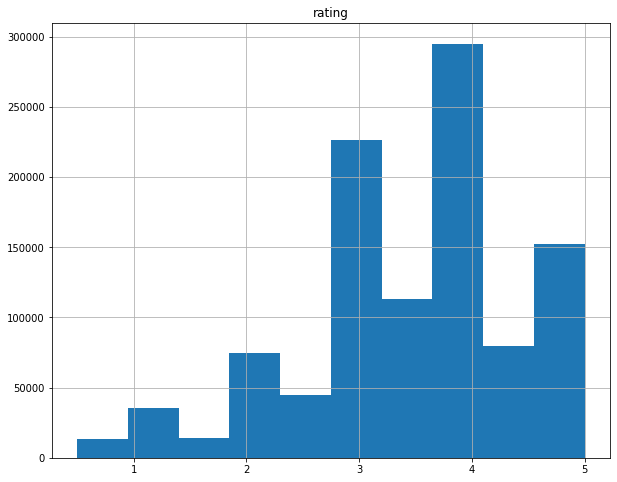

In [23]:
%matplotlib inline

ratings.hist(column='rating', figsize=(10,8))

In [24]:
tag_counts = tags['tag'].value_counts()
tag_counts[:10]

sci-fi             3384
based on a book    3281
atmospheric        2917
comedy             2779
action             2657
surreal            2427
BD-R               2334
twist ending       2323
funny              2072
dystopia           1991
Name: tag, dtype: int64

<AxesSubplot:>

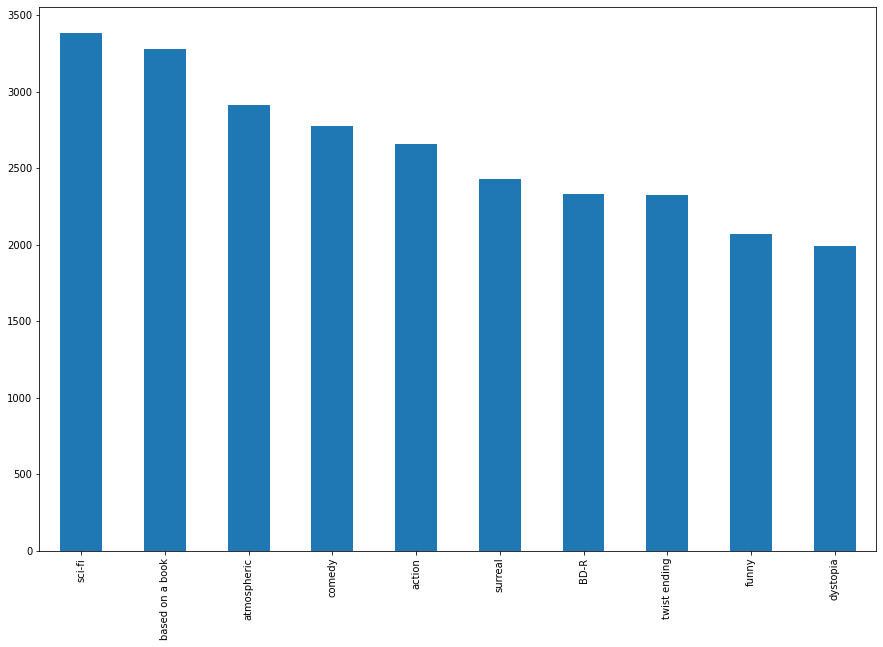

In [25]:
tag_counts[:10].plot(kind='bar', figsize=(15,10))

In [26]:
is_highly_rated = ratings['rating'] >= 4.0

ratings[is_highly_rated][-5:]

,userId,movieId,rating,timestamp
1048569,7120,163,4.5,1175542652
1048570,7120,168,5.0,1175543061
1048571,7120,253,4.0,1175542225
1048572,7120,260,5.0,1175542035
1048573,7120,261,4.0,1175543376


In [27]:
# filter for animated movies
is_animation = movies['genres'].str.contains('Animation')

In [28]:
movies[is_animation].head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
12,13,Balto (1995),Adventure|Animation|Children
47,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
236,239,"Goofy Movie, A (1995)",Animation|Children|Comedy|Romance
241,244,Gumby: The Movie (1995),Animation|Children
310,313,"Swan Princess, The (1994)",Animation|Children
360,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
388,392,"Secret Adventures of Tom Thumb, The (1993)",Adventure|Animation
547,551,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical
553,558,"Pagemaster, The (1994)",Action|Adventure|Animation|Children|Fantasy


In [29]:
ratings_count = ratings[['movieId','rating']].groupby('rating').count()
ratings_count

,movieId
rating,
0.5,13232
1.0,35144
1.5,14029
2.0,74706
2.5,44791
3.0,226202
3.5,112926
4.0,295135
4.5,79848


In [30]:
average_rating = ratings[['movieId','rating']].groupby('movieId').mean()
average_rating.tail()

,rating
movieId,
130073,2.50
130219,4.50
130462,4.00
130490,2.25
130642,3.00


In [31]:
movie_count = ratings[['movieId','rating']].groupby('movieId').count()
movie_count.head()

,rating
movieId,
1,2569
2,1155
3,685
4,138
5,657


In [32]:
movie_count = ratings[['movieId','rating']].groupby('movieId').count()
movie_count.tail()

,rating
movieId,
130073,1
130219,1
130462,1
130490,2
130642,1


<h1 style="font-size:2em;color:#2467C0">Merge Dataframes</h1>

In [33]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [34]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [35]:
# marge tags and movies dataframe
t = movies.merge(tags, on='movieId', how='inner')
t.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1644,Watched,1417736680
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741,computer animation,1183903155
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741,Disney animated feature,1183933307
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741,Pixar animation,1183934770
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741,TÃ©a Leoni does not star in this movie,1245093573


In [36]:
# as_index=False retains the current index
# otherwise moviId will be new index
avg_ratings = ratings.groupby('movieId', as_index=False).mean()
del avg_ratings['userId']
avg_ratings.head()

,movieId,rating
0,1,3.959323
1,2,3.268398
2,3,3.186861
3,4,3.000000
4,5,3.143836


In [37]:
box_office = movies.merge(avg_ratings, on='movieId', how='inner')
box_office.tail()

,movieId,title,genres,rating
14021,130073,Cinderella (2015),Adventure|Children|Drama|Sci-Fi,2.50
14022,130219,The Dark Knight (2011),Action|Crime|Drama|Thriller,4.50
14023,130462,The Boy (2015),(no genres listed),4.00
14024,130490,Insurgent (2015),Action|Romance|Sci-Fi,2.25
14025,130642,Backcountry (2014),Drama|Horror|Thriller,3.00


In [38]:
is_highly_rated = box_office['rating'] >= 4.0

box_office[is_highly_rated][-5:]

,movieId,title,genres,rating
14002,128520,The Wedding Ringer (2015),Comedy,4.0
14008,128715,Eloise at the Plaza (2003),Children|Comedy|Mystery,4.0
14010,128832,The Last Five Years (2014),Comedy|Drama|Musical|Romance,4.5
14022,130219,The Dark Knight (2011),Action|Crime|Drama|Thriller,4.5
14023,130462,The Boy (2015),(no genres listed),4.0


In [39]:
is_comedy = box_office['genres'].str.contains('Comedy')

box_office[is_comedy][:5]

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.959323
2,3,Grumpier Old Men (1995),Comedy|Romance,3.186861
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.000000
4,5,Father of the Bride Part II (1995),Comedy,3.143836
6,7,Sabrina (1995),Comedy|Romance,3.381429


In [40]:
box_office[is_comedy & is_highly_rated][-5:]

,movieId,title,genres,rating
13971,123571,Jim Jefferies: Alcoholocaust (2010),Comedy,4.25
13985,127088,Suburban Gothic (2014),Comedy|Horror,4.00
14002,128520,The Wedding Ringer (2015),Comedy,4.00
14008,128715,Eloise at the Plaza (2003),Children|Comedy|Mystery,4.00
14010,128832,The Last Five Years (2014),Comedy|Drama|Musical|Romance,4.50


<h1 style="font-size:2em;color:#2467C0"> String Vectorization</h1>


In [41]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<p style="font-family: Arial; font-size:1.35em;color:#2462C0; font-style:bold"><br>

Split 'genres' into multiple columns

<br> </p>

In [42]:
movie_genres = movies['genres'].str.split('|', expand=True)

In [43]:
movie_genres[:10]

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,Adventure,Children,Fantasy,None,None,None,None,None,None,None
2,Comedy,Romance,None,None,None,None,None,None,None,None
3,Comedy,Drama,Romance,None,None,None,None,None,None,None
4,Comedy,None,None,None,None,None,None,None,None,None
5,Action,Crime,Thriller,None,None,None,None,None,None,None
6,Comedy,Romance,None,None,None,None,None,None,None,None
7,Adventure,Children,None,None,None,None,None,None,None,None
8,Action,None,None,None,None,None,None,None,None,None
9,Action,Adventure,Thriller,None,None,None,None,None,None,None


<p style="font-family: Arial; font-size:1.35em;color:#2462C0; font-style:bold"><br>

Add a new column for comedy genre flag

<br> </p>

In [44]:
movie_genres['isComedy'] = movies['genres'].str.contains('Comedy')

In [45]:
movie_genres[:10]

,0,1,2,3,4,5,6,7,8,9,isComedy
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None,True
1,Adventure,Children,Fantasy,None,None,None,None,None,None,None,False
2,Comedy,Romance,None,None,None,None,None,None,None,None,True
3,Comedy,Drama,Romance,None,None,None,None,None,None,None,True
4,Comedy,None,None,None,None,None,None,None,None,None,True
5,Action,Crime,Thriller,None,None,None,None,None,None,None,False
6,Comedy,Romance,None,None,None,None,None,None,None,None,True
7,Adventure,Children,None,None,None,None,None,None,None,None,False
8,Action,None,None,None,None,None,None,None,None,None,False
9,Action,Adventure,Thriller,None,None,None,None,None,None,None,False


<p style="font-family: Arial; font-size:1.35em;color:#2462C0; font-style:bold"><br>

Extract year from title e.g. (1995)

<br> </p>

In [46]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)

In [47]:
movies.tail()

,movieId,title,genres,year
27273,131254,Kein Bund für's Leben (2007),Comedy,2007
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,2002
27275,131258,The Pirates (2014),Adventure,2014
27276,131260,Rentun Ruusu (2001),(no genres listed),2001
27277,131262,Innocence (2014),Adventure|Fantasy|Horror,2014


<h1 style="font-size:2em;color:#2467C0">Parsing Timestamps</h1>

In [48]:
tags = pd.read_csv('./Dataset/tags.csv', sep=',')

In [49]:
tags.dtypes

userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object

<p style="font-family: Arial; font-size:1.35em;color:#2462C0; font-style:bold">

Unix time / POSIX time / epoch time records 
time in seconds <br> since midnight Coordinated Universal Time (UTC) of January 1, 1970
</p>

In [50]:
tags.head(5)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [51]:
tags['parsed_time'] = pd.to_datetime(tags['timestamp'], unit='s')

<p style="font-family: Arial; font-size:1.35em;color:#2462C0; font-style:bold">

Data Type datetime64[ns] maps to either <M8[ns] or >M8[ns] depending on the hardware

</p>

In [52]:

tags['parsed_time'].dtype

dtype('<M8[ns]')

In [53]:
tags.head(2)

,userId,movieId,tag,timestamp,parsed_time
0,18,4141,Mark Waters,1240597180,2009-04-24 18:19:40
1,65,208,dark hero,1368150078,2013-05-10 01:41:18


<p style="font-family: Arial; font-size:1.35em;color:#2462C0; font-style:bold">

Selecting rows based on timestamps
</p>

In [54]:
greater_than_t = tags['parsed_time'] > '2015-02-01'

selected_rows = tags[greater_than_t]

tags.shape, selected_rows.shape

((465564, 5), (12130, 5))

<p style="font-family: Arial; font-size:1.35em;color:#2462C0; font-style:bold">

Sorting the table using the timestamps
</p>

In [55]:
tags.sort_values(by='parsed_time', ascending=True)[:10]

,userId,movieId,tag,timestamp,parsed_time
333932,100371,2788,monty python,1135429210,2005-12-24 13:00:10
333927,100371,1732,coen brothers,1135429236,2005-12-24 13:00:36
333924,100371,1206,stanley kubrick,1135429248,2005-12-24 13:00:48
333923,100371,1193,jack nicholson,1135429371,2005-12-24 13:02:51
333939,100371,5004,peter sellers,1135429399,2005-12-24 13:03:19
333922,100371,47,morgan freeman,1135429412,2005-12-24 13:03:32
333921,100371,47,brad pitt,1135429412,2005-12-24 13:03:32
333936,100371,4011,brad pitt,1135429431,2005-12-24 13:03:51
333937,100371,4011,guy ritchie,1135429431,2005-12-24 13:03:51
333920,100371,32,bruce willis,1135429442,2005-12-24 13:04:02


<h1 style="font-size:2em;color:#2467C0">Average Movie Ratings over Time </h1>
## Are Movie Ratings related to the Year of Launch?

In [56]:
average_rating = ratings[['movieId','rating']].groupby('movieId', as_index=False).mean()
average_rating.tail()

,movieId,rating
14021,130073,2.50
14022,130219,4.50
14023,130462,4.00
14024,130490,2.25
14025,130642,3.00


In [57]:
joined = movies.merge(average_rating, on='movieId', how='inner')
joined.head()
joined.corr()

,movieId,rating
movieId,1.00000,-0.01041
rating,-0.01041,1.00000


In [58]:
yearly_average = joined[['year','rating']].groupby('year', as_index=False).mean()
yearly_average[:10]

,year,rating
0,1898,4.000
1,1900,3.500
2,1902,3.700
3,1903,4.250
4,1909,1.500
5,1910,3.000
6,1912,3.000
7,1913,4.500
8,1914,1.375
9,1915,3.500


<AxesSubplot:xlabel='year'>

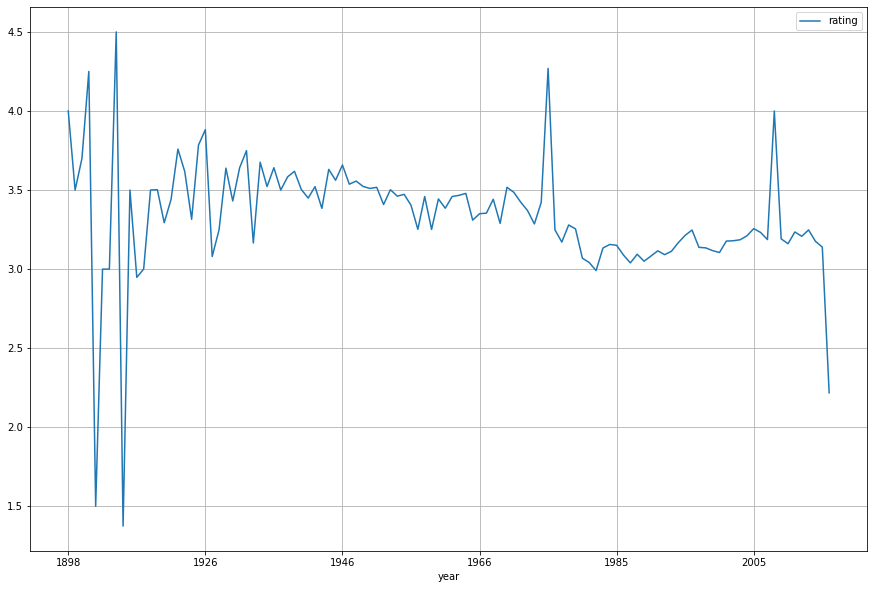

In [59]:
yearly_average.plot(x='year', y='rating', figsize=(15,10), grid=True)

In [60]:
#extracting required columns
ratings = ratings[['userId', 'movieId','rating']]
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [61]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings_df = ratings.groupby(['userId','movieId'], as_index=False).aggregate(np.max)

In [62]:
ratings_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [63]:
len(ratings_df) - len(ratings)

0

No change in dataframe length means user hasn't rated the same movie twice

In [64]:
ratings_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [65]:
# Counting no of unique users
len(ratings['userId'].unique())

7120

In [66]:
count_ratings = ratings.groupby('rating').count()
count_ratings

,userId,movieId
rating,,
0.5,13232,13232
1.0,35144,35144
1.5,14029,14029
2.0,74706,74706
2.5,44791,44791
3.0,226202,226202
3.5,112926,112926
4.0,295135,295135
4.5,79848,79848


In [67]:
# inspecting various genres
genres = movies['genres']

In [68]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [69]:
genre_list = ""
for index,row in movies.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#inspect list of genres
new_list

['IMAX',
 'Fantasy',
 'Crime',
 'Adventure',
 'Thriller',
 '(no genres listed)',
 'Horror',
 'War',
 'Documentary',
 'Action',
 'Western',
 'Film-Noir',
 'Romance',
 'Animation',
 'Sci-Fi',
 'Musical',
 'Drama',
 'Mystery',
 'Children',
 'Comedy']

In [70]:
#Enriching the movies dataset by adding the various genres columns.
movies_with_genres = movies.copy()

for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

In [71]:
movies_with_genres.head()

,movieId,title,genres,year,IMAX,Fantasy,Crime,Adventure,Thriller,(no genres listed),...,Western,Film-Noir,Romance,Animation,Sci-Fi,Musical,Drama,Mystery,Children,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [72]:
#Calculating the sparsity
no_of_users = len(ratings['userId'].unique())
no_of_movies = len(ratings['movieId'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)
print(sparsity)

0.99


In [73]:
# Counting the number of unique movies in the dataset.
len(ratings['movieId'].unique())

14026

In [74]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index

In [75]:
# inspecting the average movie rating data frame
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [76]:
len(avg_movie_rating)

14026

In [77]:
#calculate the percentile count. It gives the no of ratings at least 70% of the movies have
np.percentile(avg_movie_rating['count'],70)

30.0

In [78]:
#Get the average movie rating across all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [79]:
len(movie_score)

4173

In [80]:
!ls

Dataset  images  movie_recommendation.ipynb


<img src="./images/IBM_formula.png"></img>


In [81]:
#create a function for weighted rating score based on count of reviews
def weighted_rating(x, m=min_reviews, C=avg_rating_all):
    v = x['count']
    R = x['mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [82]:
#Calculating the weighted score for each movie
weighted_score_ = movie_score.apply(weighted_rating, axis=1)
movie_score = movie_score.assign(weighted_score=weighted_score_)

In [83]:
movie_score = movie_score.reset_index(drop=True)
movie_score.head()

,mean,count,movieId,weighted_score
0,3.959323,2569,1,3.954359
1,3.268398,1155,2,3.275003
2,3.186861,685,3,3.201228
3,3.000000,138,4,3.094513
4,3.143836,657,5,3.160667


In [84]:
#join movie details to movie ratings
movie_score = pd.merge(movie_score,movies_with_genres)
movie_score.head()

,mean,count,movieId,weighted_score,title,genres,year,IMAX,Fantasy,Crime,...,Western,Film-Noir,Romance,Animation,Sci-Fi,Musical,Drama,Mystery,Children,Comedy
0,3.959323,2569,1,3.954359,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,1,0,...,0,0,0,1,0,0,0,0,1,1
1,3.268398,1155,2,3.275003,Jumanji (1995),Adventure|Children|Fantasy,1995,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,3.186861,685,3,3.201228,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3.000000,138,4,3.094513,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,3.143836,657,5,3.160667,Father of the Bride Part II (1995),Comedy,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [85]:
#list top scored movies over the whole range of movies
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

,title,count,mean,weighted_score,genres
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299,Crime|Drama
565,"Godfather, The (1972)",2137,4.388161,4.376270,Crime|Drama
46,"Usual Suspects, The (1995)",2490,4.370482,4.360468,Crime|Mystery|Thriller
403,Schindler's List (1993),2598,4.295612,4.286864,Drama|War
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037,Crime|Drama
3230,Band of Brothers (2001),228,4.353070,4.257280,Action|Drama|War
593,Casablanca (1942),1282,4.268721,4.251813,Drama|Romance
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151,Action|Adventure|Crime|Drama|Thriller
589,North by Northwest (1959),817,4.250306,4.224768,Action|Adventure|Mystery|Romance|Thriller
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788,Action|Crime|Drama|IMAX


In [86]:
# Gives the best movies according to genre based on weighted score which is calculated using IMDB formula
def best_movies_by_genre(genre,top_n):
    return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

In [87]:
#run function to return top recommended movies by genre
best_movies_by_genre('Musical',10)  

,title,count,mean,weighted_score
824,Duck Soup (1933),280,4.217857,4.151220
580,Singin' in the Rain (1952),542,4.097786,4.067969
3909,Dr. Horrible's Sing-Along Blog (2008),185,4.148649,4.062224
1777,Stop Making Sense (1984),119,4.142857,4.019316
2647,Fiddler on the Roof (1971),165,4.048485,3.968606
600,"Wizard of Oz, The (1939)",1229,3.947518,3.937552
588,"Gay Divorcee, The (1934)",57,4.149123,3.935381
1438,Nashville (1975),128,4.015625,3.923279
624,Top Hat (1935),120,4.004167,3.909188
3297,"Day at the Races, A (1937)",51,4.117647,3.899730


In [88]:
#run function to return top recommended movies by genre
best_movies_by_genre('Action',10)  

,title,count,mean,weighted_score
3230,Band of Brothers (2001),228,4.353070,4.257280
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151
589,North by Northwest (1959),817,4.250306,4.224768
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788
1838,Fight Club (1999),2085,4.219185,4.209399
769,Raiders of the Lost Ark (Indiana Jones and the...,2289,4.206204,4.197446
1256,Seven Samurai (Shichinin no samurai) (1954),594,4.223906,4.190510
199,Star Wars: Episode IV - A New Hope (1977),2874,4.189457,4.182637
1629,"Matrix, The (1999)",2705,4.176340,4.169242
768,"Princess Bride, The (1987)",1725,4.177391,4.166312


In [89]:
#run function to return top recommended movies by genre
best_movies_by_genre('Children',10)  

,title,count,mean,weighted_score
518,Wallace & Gromit: A Close Shave (1995),622,4.176045,4.146286
741,Wallace & Gromit: The Wrong Trousers (1993),798,4.133459,4.111568
793,"Grand Day Out with Wallace and Gromit, A (1989)",379,4.100264,4.058382
3833,WALL·E (2008),654,4.074159,4.050260
2927,My Neighbor Totoro (Tonari no Totoro) (1988),262,4.104962,4.045816
1753,"Christmas Story, A (1983)",686,4.035714,4.014495
3991,How to Train Your Dragon (2010),234,4.064103,4.003326
3931,Up (2009),502,4.030876,4.002591
4004,Toy Story 3 (2010),306,4.042484,3.996661
2989,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,183,4.046448,3.973606


In [90]:
#run function to return top recommended movies by genre
best_movies_by_genre('Drama',10)  

,title,count,mean,weighted_score
242,"Shawshank Redemption, The (1994)",3216,4.469994,4.461299
565,"Godfather, The (1972)",2137,4.388161,4.376270
403,Schindler's List (1993),2598,4.295612,4.286864
791,"Godfather: Part II, The (1974)",1418,4.278561,4.263037
3230,Band of Brothers (2001),228,4.353070,4.257280
593,Casablanca (1942),1282,4.268721,4.251813
2937,City of God (Cidade de Deus) (2002),646,4.258514,4.226151
3814,"Dark Knight, The (2008)",1031,4.242968,4.222788
765,One Flew Over the Cuckoo's Nest (1975),1538,4.235696,4.222180
1838,Fight Club (1999),2085,4.219185,4.209399


In [91]:
# Creating a data frame that has user ratings accross all movies in form of matrix 
ratings_df = pd.pivot_table(ratings, index='userId', columns='movieId', aggfunc=np.max)

In [92]:
ratings_df.shape

(7120, 14026)

In [93]:
#merging ratings and movies dataframes
ratings_movies = pd.merge(ratings,movies, on = 'movieId')

In [94]:
ratings_movies.head()

,userId,movieId,rating,title,genres,year
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy,1995
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995


In [95]:
#Gets the other top N movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name, n=10):
    #get all users who watched a specific movie
    df_movie_users_series = ratings_movies.loc[ratings_movies['title']==movie_name]['userId']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,ratings_movies,on='userId')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
    other_users_watched['perc_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
    return other_users_watched[:n]

In [96]:
# Getting other top 5 movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Gone Girl (2014)', n=5)

,userId,perc_who_watched
title,,
Gone Girl (2014),61,100.0
"Matrix, The (1999)",54,88.5
Inception (2010),53,86.9
Fight Club (1999),52,85.2
"Shawshank Redemption, The (1994)",52,85.2


In [97]:
from sklearn.neighbors import NearestNeighbors


In [98]:
avg_movie_rating.head()

,mean,count,movieId
movieId,,,
1,3.959323,2569,1
2,3.268398,1155,2
3,3.186861,685,3
4,3.000000,138,4
5,3.143836,657,5


In [99]:
#only include movies with more than 10 ratings
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
movie_plus_10_ratings = movie_plus_10_ratings.reset_index(drop=True)
print(len(movie_plus_10_ratings))

6870


In [100]:
movie_plus_10_ratings.head()

,mean,count,movieId
0,3.959323,2569,1
1,3.268398,1155,2
2,3.186861,685,3
3,3.000000,138,4
4,3.143836,657,5


In [101]:
filtered_ratings = pd.merge(movie_plus_10_ratings, ratings, on="movieId")
len(filtered_ratings)

1025973

In [102]:
filtered_ratings.head()

,mean,count,movieId,userId,rating
0,3.959323,2569,1,3,4.0
1,3.959323,2569,1,6,5.0
2,3.959323,2569,1,8,4.0
3,3.959323,2569,1,10,4.0
4,3.959323,2569,1,11,4.5


In [103]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

userId,1,2,3,4,5,6,7,8,9,10,...,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,5.0,4.5
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,3.5,0.0,0.0,0.0,0.0


In [104]:
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(movie_wide)


NearestNeighbors(algorithm='brute', metric='cosine')

In [105]:
#Gets the top N nearest neighbours got the movie
def print_similar_movies(query_index, n=10) :
    #get the list of user ratings for a specific userId
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = n+1) 
    #lopp that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = movies.loc[movies['movieId']==query_index]['title']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = movies.loc[movies['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [106]:
print_similar_movies(112552)

Recommendations for 23663    Whiplash (2014)
Name: title, dtype: object:

1: 24693    The Imitation Game (2014)
Name: title, dtype: object, with distance of 0.5315254432260329:
2: 23561    Birdman (2014)
Name: title, dtype: object, with distance of 0.6297852813391156:
3: 23665    Gone Girl (2014)
Name: title, dtype: object, with distance of 0.6333635271762286:
4: 24387    Nightcrawler (2014)
Name: title, dtype: object, with distance of 0.6489868540544907:
5: 23401    Chef (2014)
Name: title, dtype: object, with distance of 0.6553093708289104:
6: 22189    Inside Llewyn Davis (2013)
Name: title, dtype: object, with distance of 0.6673366942887282:
7: 21749    Nebraska (2013)
Name: title, dtype: object, with distance of 0.6764847438525627:
8: 22919    Interstellar (2014)
Name: title, dtype: object, with distance of 0.687531270800998:
9: 18064    Shame (2011)
Name: title, dtype: object, with distance of 0.7232374343153795:
10: 24308    Fury (2014)
Name: title, dtype: object, with distance o

In [107]:
print_similar_movies(1)

Recommendations for 0    Toy Story (1995)
Name: title, dtype: object:

1: 257    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object, with distance of 0.42037021829409127:
2: 767    Independence Day (a.k.a. ID4) (1996)
Name: title, dtype: object, with distance of 0.4264775268701727:
3: 1184    Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object, with distance of 0.44730365269962336:
4: 352    Forrest Gump (1994)
Name: title, dtype: object, with distance of 0.4568987253772405:
5: 640    Mission: Impossible (1996)
Name: title, dtype: object, with distance of 0.45773656489588577:
6: 3027    Toy Story 2 (1999)
Name: title, dtype: object, with distance of 0.46030175876509594:
7: 1242    Back to the Future (1985)
Name: title, dtype: object, with distance of 0.46115899489577805:
8: 582    Aladdin (1992)
Name: title, dtype: object, with distance of 0.4672019854501791:
9: 476    Jurassic Park (1993)
Name: title, dtype: object, with distance of 0.4680072

In [108]:
movies_with_genres.head()

,movieId,title,genres,year,IMAX,Fantasy,Crime,Adventure,Thriller,(no genres listed),...,Western,Film-Noir,Romance,Animation,Sci-Fi,Musical,Drama,Mystery,Children,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [109]:
#Getting the movies list with only genres like Musical and other such columns
movie_content_df_temp = movies_with_genres.copy()
movie_content_df_temp.set_index('movieId')
movie_content_df = movie_content_df_temp.drop(columns = ['movieId','title','genres','year'])
movie_content_df = movie_content_df.to_numpy()
movie_content_df

array([[0, 1, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [110]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(movie_content_df,movie_content_df)

In [111]:
# Similarity of the movies based on the content
cosine_sim

array([[5., 3., 1., ..., 1., 0., 2.],
       [3., 3., 0., ..., 1., 0., 2.],
       [1., 0., 2., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [2., 2., 0., ..., 1., 0., 3.]])

In [112]:
#create a series of the movie id and title
indicies = pd.Series(movie_content_df_temp.index, movie_content_df_temp['title'])
indicies 

title
Toy Story (1995)                          0
Jumanji (1995)                            1
Grumpier Old Men (1995)                   2
Waiting to Exhale (1995)                  3
Father of the Bride Part II (1995)        4
                                      ...  
Kein Bund für's Leben (2007)          27273
Feuer, Eis & Dosenbier (2002)         27274
The Pirates (2014)                    27275
Rentun Ruusu (2001)                   27276
Innocence (2014)                      27277
Length: 27278, dtype: int64

In [113]:
#Gets the top N similar movies based on the content
def get_similar_movies_based_on_content(movie_index, n=10) :
    sim_scores = list(enumerate(cosine_sim[movie_index]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
   
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[0:n+1]
    print(sim_scores)
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    similar_movies = pd.DataFrame(movie_content_df_temp[['title','genres']].iloc[movie_indices])
    return similar_movies

In [114]:
indicies["Skyfall (2012)"]

19338

In [115]:
get_similar_movies_based_on_content(19338)

[(6260, 4.0), (6822, 4.0), (11018, 4.0), (11826, 4.0), (15203, 4.0), (16733, 4.0), (18315, 4.0), (18349, 4.0), (19338, 4.0), (20615, 4.0), (9, 3.0)]
[6260, 6822, 11018, 11826, 15203, 16733, 18315, 18349, 19338, 20615, 9]


,title,genres
6260,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
6822,"Matrix Revolutions, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
11018,Poseidon (2006),Action|Adventure|Thriller|IMAX
11826,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX
15203,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX
16733,Sanctum (2011),Action|Adventure|Drama|Thriller|IMAX
18315,"Bourne Legacy, The (2012)",Action|Adventure|Drama|Thriller|IMAX
18349,Mission: Impossible - Ghost Protocol (2011),Action|Adventure|Thriller|IMAX
19338,Skyfall (2012),Action|Adventure|Thriller|IMAX
20615,G.I. Joe: Retaliation (2013),Action|Adventure|Sci-Fi|Thriller|IMAX


In [116]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()


,movieId,movie_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [117]:
#get ordered list of movieIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

,userId,user_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [118]:
#join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#inspec the data frame
df_with_index.head()

,userId,movieId,rating,movie_index,user_index
0,1,2,3.5,1,0
1,1,29,3.5,28,0
2,1,32,3.5,31,0
3,1,47,3.5,46,0
4,1,50,3.5,49,0


In [119]:
#import train_test_split module
from sklearn.model_selection import train_test_split
#take 80% as the training set and 20% as the test set
df_train, df_test= train_test_split(df_with_index,test_size=0.2)
print(len(df_train))
print(len(df_test))

838860
209715


In [120]:
df_train.head()

,userId,movieId,rating,movie_index,user_index
223337,3864,46723,3.5,9472,3863
445519,4150,2133,4.0,1993,4149
579805,3358,106642,4.0,13474,3357
873274,6564,11,4.0,10,6563
396156,7110,1676,3.0,1580,7109


In [121]:
df_test.head()

,userId,movieId,rating,movie_index,user_index
609534,4290,30707,4.5,8506,4289
184069,3293,4881,3.5,4633,3292
75012,1374,1061,3.0,1018,1373
282034,4760,4980,2.0,4725,4759
373610,6614,4681,2.5,4442,6613


In [122]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print(n_users)
print(n_items)

7120
14026


In [123]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_train.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

(7120, 14026)

In [124]:
#Create two user-item matrices, one for training and another for testing
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test[:1].itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    #print(line[2])
    test_data_matrix[line[5], line[4]] = line[3]
    #train_data_matrix[line['movieId'], line['userId']] = line['rating']
test_data_matrix.shape

(7120, 14026)

In [125]:
pd.DataFrame(train_data_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
df_train['rating'].max()

5.0

In [127]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    #select prediction values that are non-zero and flatten into 1 array
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #select test values that are non-zero and flatten into 1 array
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #return RMSE between values
    return sqrt(mean_squared_error(prediction, ground_truth))

<img src="./images/svd.jpg"></img>

In [128]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
rmse_list = []
for i in [1,2,5,20,40,60]:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions
    rmse_score = rmse(X_pred,test_data_matrix)
    rmse_list.append(rmse_score)
    print("Matrix Factorisation with " + str(i) +" latent features has a RMSE of " + str(rmse_score))

Matrix Factorisation with 1 latent features has a RMSE of 3.7396164034356767
Matrix Factorisation with 2 latent features has a RMSE of 3.7657863417676527
Matrix Factorisation with 5 latent features has a RMSE of 3.95977966012093
Matrix Factorisation with 20 latent features has a RMSE of 3.7940064017538746
Matrix Factorisation with 40 latent features has a RMSE of 3.9438426387583143
Matrix Factorisation with 60 latent features has a RMSE of 3.70521431016417


In [129]:
#Convert predictions to a DataFrame
mf_pred = pd.DataFrame(X_pred)
mf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,0.311017,0.470448,-0.007408,-0.007879,-0.233358,0.157943,-0.311298,-0.054720,-0.143710,-0.056204,...,0.010084,-0.006630,0.006247,0.0,-0.002813,0.003343,-0.014272,-0.006015,0.013833,-0.008440
1,0.290603,0.239322,0.463249,0.021154,0.294514,0.051128,0.350119,0.021800,0.087602,-0.320155,...,-0.002068,-0.006511,0.005287,0.0,0.001765,0.002497,-0.007734,0.003714,0.003767,0.005295
2,3.380035,0.795982,-0.108444,-0.023421,-0.037383,-0.341405,-0.000821,0.029518,-0.093863,0.795753,...,-0.006325,0.007477,0.017907,0.0,-0.000731,0.017201,-0.009603,0.008784,-0.003745,-0.002194
3,-0.554116,0.522302,0.203069,0.003432,0.128274,0.344723,-0.018231,0.068432,0.173345,1.110446,...,-0.001118,0.001194,-0.001035,0.0,-0.000513,-0.002116,0.002224,-0.000661,-0.001302,-0.001540
4,0.292170,1.124790,0.889361,0.057274,0.802156,0.392081,1.025669,0.152965,0.197134,0.823014,...,0.001124,0.006019,-0.007967,0.0,-0.000467,0.002752,0.001231,0.003805,-0.000206,-0.001400


In [130]:
df_names = pd.merge(ratings,movies,on='movieId')
df_names.head()

,userId,movieId,rating,title,genres,year
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy,1995
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy,1995


In [131]:
def movie_rated_by_user_x(userID):
    user_id = userID
    #get movies rated by this user id
    users_movies = df_names.loc[df_names["userId"]==user_id]
    #print how many ratings user has made 
    print("User ID : " + str(user_id) + " has already rated " + str(len(users_movies)) + " movies")
    #list movies that have been rated
    return users_movies

In [132]:
users_movies = movie_rated_by_user_x(userID=1)
users_movies.head()

User ID : 1 has already rated 175 movies


,userId,movieId,rating,title,genres,year
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy,1995
1155,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,1995
1603,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,1995
3915,1,47,3.5,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
6156,1,50,3.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995


In [133]:
# returns a data frame containing prediction for a user 
def recomm_movie_for_user(user_id=0):
    user_index = df_train.loc[df_train["userId"]==user_id]['user_index'][:1].values[0]
    #get movie ratings predicted for this user and sort by highest rating prediction
    sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
    #rename the columns
    sorted_user_predictions.columns=['ratings']
    #save the index values as movie id
    sorted_user_predictions['movieId']=sorted_user_predictions.index
    print( "Predictions for User " + str(user_id))
    recomm = pd.merge(sorted_user_predictions,movies, on = 'movieId')
    return recomm


**Making recommendation for a user**

In [134]:
#movie recommendation for user 1
recomm = recomm_movie_for_user(user_id=1)
recomm.head(10)

Predictions for User 1


,ratings,movieId,title,genres,year
0,5.445998,4738,Happy Accidents (2000),Romance|Sci-Fi,2000
1,4.760227,5622,Charly (2002),Comedy|Drama|Romance,2002
2,4.249195,254,Jefferson in Paris (1995),Drama,1995
3,4.106453,312,Stuart Saves His Family (1995),Comedy,1995
4,3.787925,46,How to Make an American Quilt (1995),Drama|Romance,1995
5,3.714640,6699,Once Upon a Time in the Midlands (2002),Drama,2002
6,3.666530,1159,Love in Bloom (1935),Romance,1935
7,3.619215,1088,Dirty Dancing (1987),Drama|Musical|Romance,1987
8,3.323794,1142,Get Over It (1996),Drama,1996
9,3.156722,290,Once Were Warriors (1994),Crime|Drama,1994
